In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pickle
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

## run baseline models 

In [2]:
# load the necessary functions from the analysis package

# load the variable names, this allows to access the variables in the feature data in a compact way
from analysis_utils.variable_names import *

# load flagged ids 
from analysis_utils.flagged_uids import flagged_uids

# load the functions to do spatial k-fold CV
from analysis_utils.spatial_CV import split_lsms_spatial

# load the helper functions
from analysis_utils.analysis_helpers import *

# load the random forest trainer and cross_validator
import analysis_utils.RandomForest as rf

# load the combien model
from analysis_utils.CombinedModel import CombinedModel

In [3]:
# set the global file paths
root_data_dir = "../../Data"

# the lsms data
lsms_pth = f"{root_data_dir}/lsms/processed/labels_cluster_v1.csv"

# the feature data
feat_data_pth = f"{root_data_dir}/feature_data/tabular_data.csv"

# set the random seed
random_seed = 423
spatial_cv_random_seed = 348

# set the number of folds for k-fold CV
n_folds = 5

In [4]:
# load the feature and the label data
lsms_df = pd.read_csv(lsms_pth)
# remove flagged ids form dataset
lsms_df = lsms_df[~lsms_df.unique_id.isin(flagged_uids)].reset_index()
lsms_df['avg_log_mean_pc_cons_usd_2017'] = lsms_df.groupby('cluster_id')['log_mean_pc_cons_usd_2017'].transform('mean')
lsms_df['avg_mean_asset_index_yeh'] = lsms_df.groupby('cluster_id')['mean_asset_index_yeh'].transform('mean')
feat_df = pd.read_csv(feat_data_pth)

# merge the label and the feature data to one dataset
lsms_vars = ['unique_id', 'n_households',           
             'log_mean_pc_cons_usd_2017', 'avg_log_mean_pc_cons_usd_2017',
             'mean_asset_index_yeh', 'avg_mean_asset_index_yeh']
df = pd.merge(lsms_df[lsms_vars], feat_df, on = 'unique_id', how = 'left')

# get the training and validation split
fold_ids = split_lsms_spatial(lsms_df, n_folds = n_folds, random_seed = spatial_cv_random_seed)

# describe the training data broadly
print(f"Number of observations {len(lsms_df)}")
print(f"Number of clusters {len(np.unique(lsms_df.cluster_id))}")
print(f"Number of x vars {len(feat_df.columns)-2}")

Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Number of observations 6401
Number of clusters 2128
Number of x vars 113


In [5]:
# define the within and between x variables
avg_rs_vars = avg_ndvi_vars + avg_ndwi_gao_vars + avg_nl_vars
osm_vars = osm_dist_vars + osm_count_vars + osm_road_vars
between_x_vars = osm_vars + esa_lc_vars + wsf_vars + avg_rs_vars + avg_preciptiation



### Consumption Expenditure

In [6]:
# run Cross validation for consumption expenditure
between_target_var = 'avg_log_mean_pc_cons_usd_2017'
cl_df = df[['cluster_id', between_target_var] + between_x_vars].drop_duplicates().reset_index(drop = True)

# normalise the feature data
cl_df_norm = standardise_df(cl_df, exclude_cols = [between_target_var])

# run the bewtween training
print('Between training')
baseline_cons = rf.CrossValidator(cl_df_norm, 
                                            fold_ids, 
                                            between_target_var, 
                                            between_x_vars, 
                                            id_var = 'cluster_id', 
                                            random_seed = random_seed)
baseline_cons.run_cv_training(min_samples_leaf = 1)

Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 178 seconds


### Asset index

In [7]:
# run Cross validation for consumption expenditure
between_target_var = 'avg_mean_asset_index_yeh'
cl_df = df[['cluster_id', between_target_var] + between_x_vars].drop_duplicates().reset_index(drop = True)

# normalise the feature data
cl_df_norm = standardise_df(cl_df, exclude_cols = [between_target_var])

# run the bewtween training
print('Between training')
baseline_asset = rf.CrossValidator(cl_df_norm, 
                                            fold_ids, 
                                            between_target_var, 
                                            between_x_vars, 
                                            id_var = 'cluster_id', 
                                            random_seed = random_seed)
baseline_asset.run_cv_training(min_samples_leaf = 1)

Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 178 seconds


# Make plot

In [10]:
# load the dl consumption and the dl asset results
results_dir = "results"
dl_cons_pth = f"{results_dir}/model_objects/between_cons.pkl"
dl_asset_pth = f"{results_dir}/model_objects/between_asset.pkl"

with open(dl_cons_pth, 'rb') as f:
    dl_cons = pickle.load(f)
    
with open(dl_asset_pth, 'rb') as f:
    dl_asset = pickle.load(f)

In [29]:
# create labels for the plot

ls_vars = ['ls_feat_'+str(i) for i in range(0,25)]
rs_vars = ['rs_feat_'+str(i) for i in range(0,25)]

ls_var_labels = ['ls pc '+str(i) for i in range(1,26)]
rs_var_labels = ['rs pc '+str(i) for i in range(1,26)]

osm_count_labels = ["# " + i.split("_")[0] for i in osm_count_vars]
osm_dist_labels = ["D " + i.split("_")[0] for i in osm_dist_vars]
osm_road_labels = ["road network length", "D paved road", "D primary road"]

ls_rs_label_dict = dict(zip(ls_vars+rs_vars,ls_var_labels+rs_var_labels))
osm_label_dict = dict(zip(osm_count_vars + osm_dist_vars + osm_road_vars, osm_count_labels + osm_dist_labels + osm_road_labels))
precip_label_dict = {'avg_precipitation':'precipitation'}

rs_vars = avg_ndvi_vars + avg_ndwi_gao_vars + avg_nl_vars 
rs_var_labels = [i.replace('avg_',"").replace("_"," ") for i in rs_vars]
wsf_var_labels = [i.replace("_"," ") for i in wsf_vars]
esa_lc_var_labels = esa_lc_vars

rs_labels = rs_var_labels + wsf_var_labels + esa_lc_var_labels
rs_names = rs_vars + wsf_vars + esa_lc_vars

rs_label_dict = dict(zip(rs_names, rs_labels))


label_dict = {}

# Merge the dictionaries
label_dict.update(ls_rs_label_dict)
label_dict.update(osm_label_dict)
label_dict.update(precip_label_dict)
label_dict.update(rs_label_dict)

In [30]:
dl_cons.feat_importance['var_label'] = [label_dict[i] for i in dl_cons.feat_importance['variable_name']]
dl_asset.feat_importance['var_label'] = [label_dict[i] for i in dl_asset.feat_importance['variable_name']]

# get feature importance for the baseline models
baseline_cons_feat_importance = baseline_cons.get_feature_importance()
baseline_asset_feat_importance = baseline_asset.get_feature_importance()

baseline_cons_feat_importance['var_label'] = [label_dict[i] for i in baseline_cons_feat_importance['variable_name']]
baseline_asset_feat_importance['var_label'] = [label_dict[i] for i in baseline_asset_feat_importance['variable_name']]

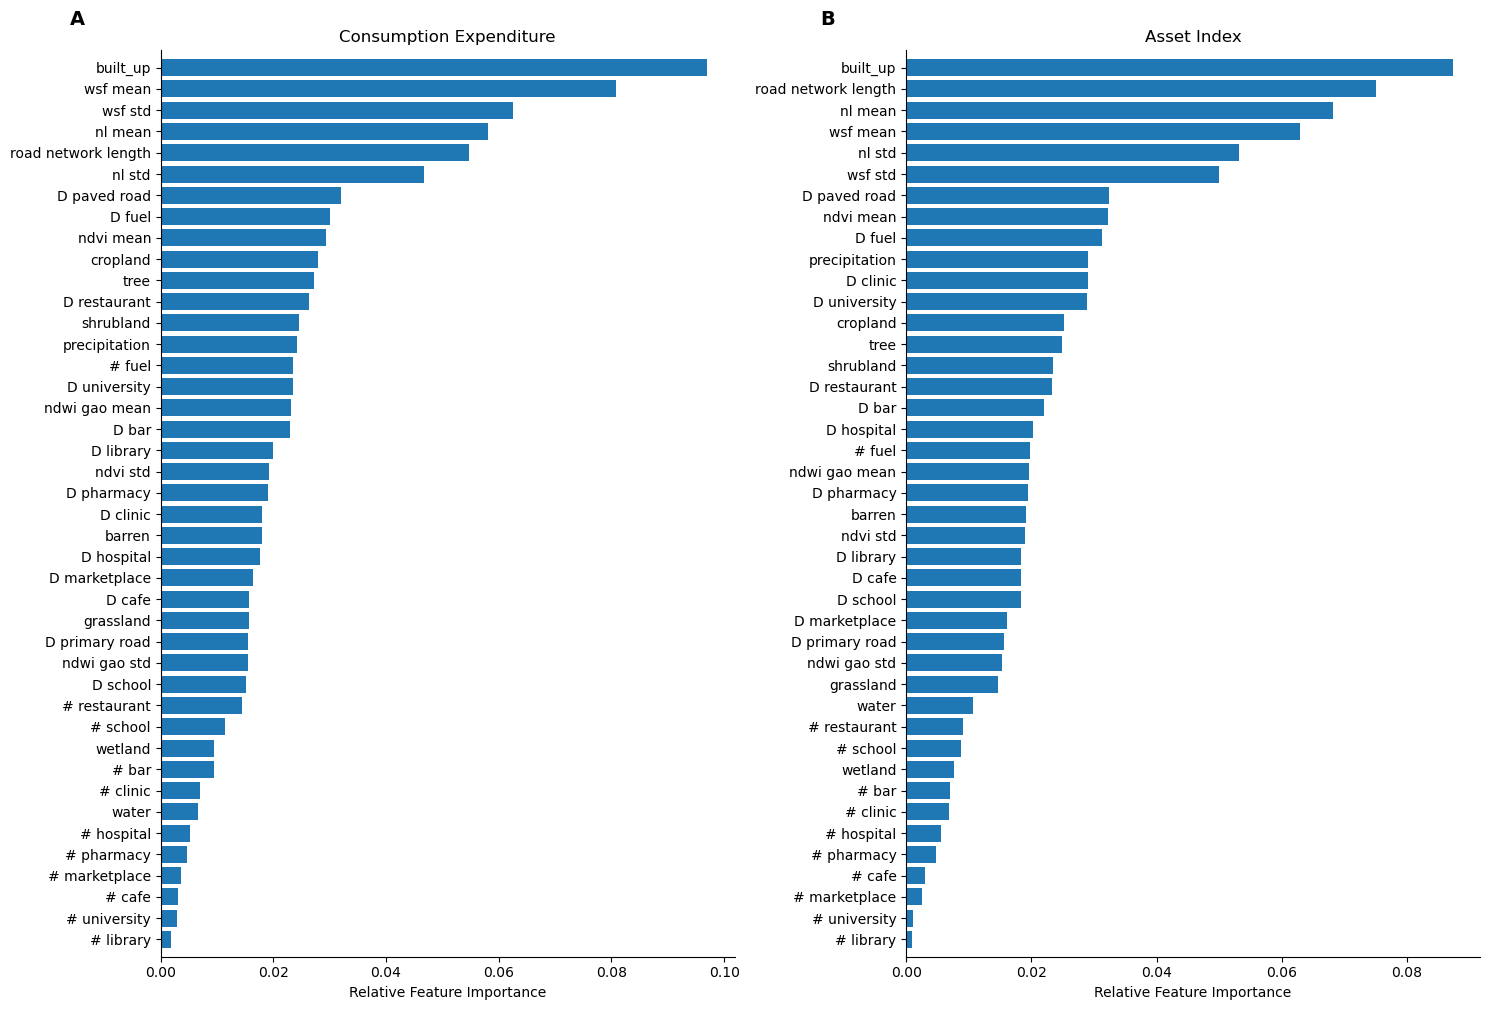

In [86]:
# finish labels and plot data...
fig, ax = plt.subplots(1,2,figsize = (15,10))

ax[0].set_ymargin(0.01)
ax[0].barh(y = baseline_cons_feat_importance['var_label'], width = baseline_cons_feat_importance['feat_importance'])    
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].set_xlabel("Relative Feature Importance")
ax[0].set_title('Consumption Expenditure')


ax[1].set_ymargin(0.01)
ax[1].barh(y = baseline_asset_feat_importance['var_label'], width = baseline_asset_feat_importance['feat_importance'])    
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].set_xlabel("Relative Feature Importance")
ax[1].set_title('Asset Index')

fig.text(0.05,.99,'A',weight = 'bold', size = 14)
fig.text(0.55,.99,'B',weight = 'bold', size = 14)

plt.tight_layout()
pth = '../figures/results/baseline_feature_importance.png'
plt.savefig(pth, dpi = 300, bbox_inches = 'tight')
plt.show()


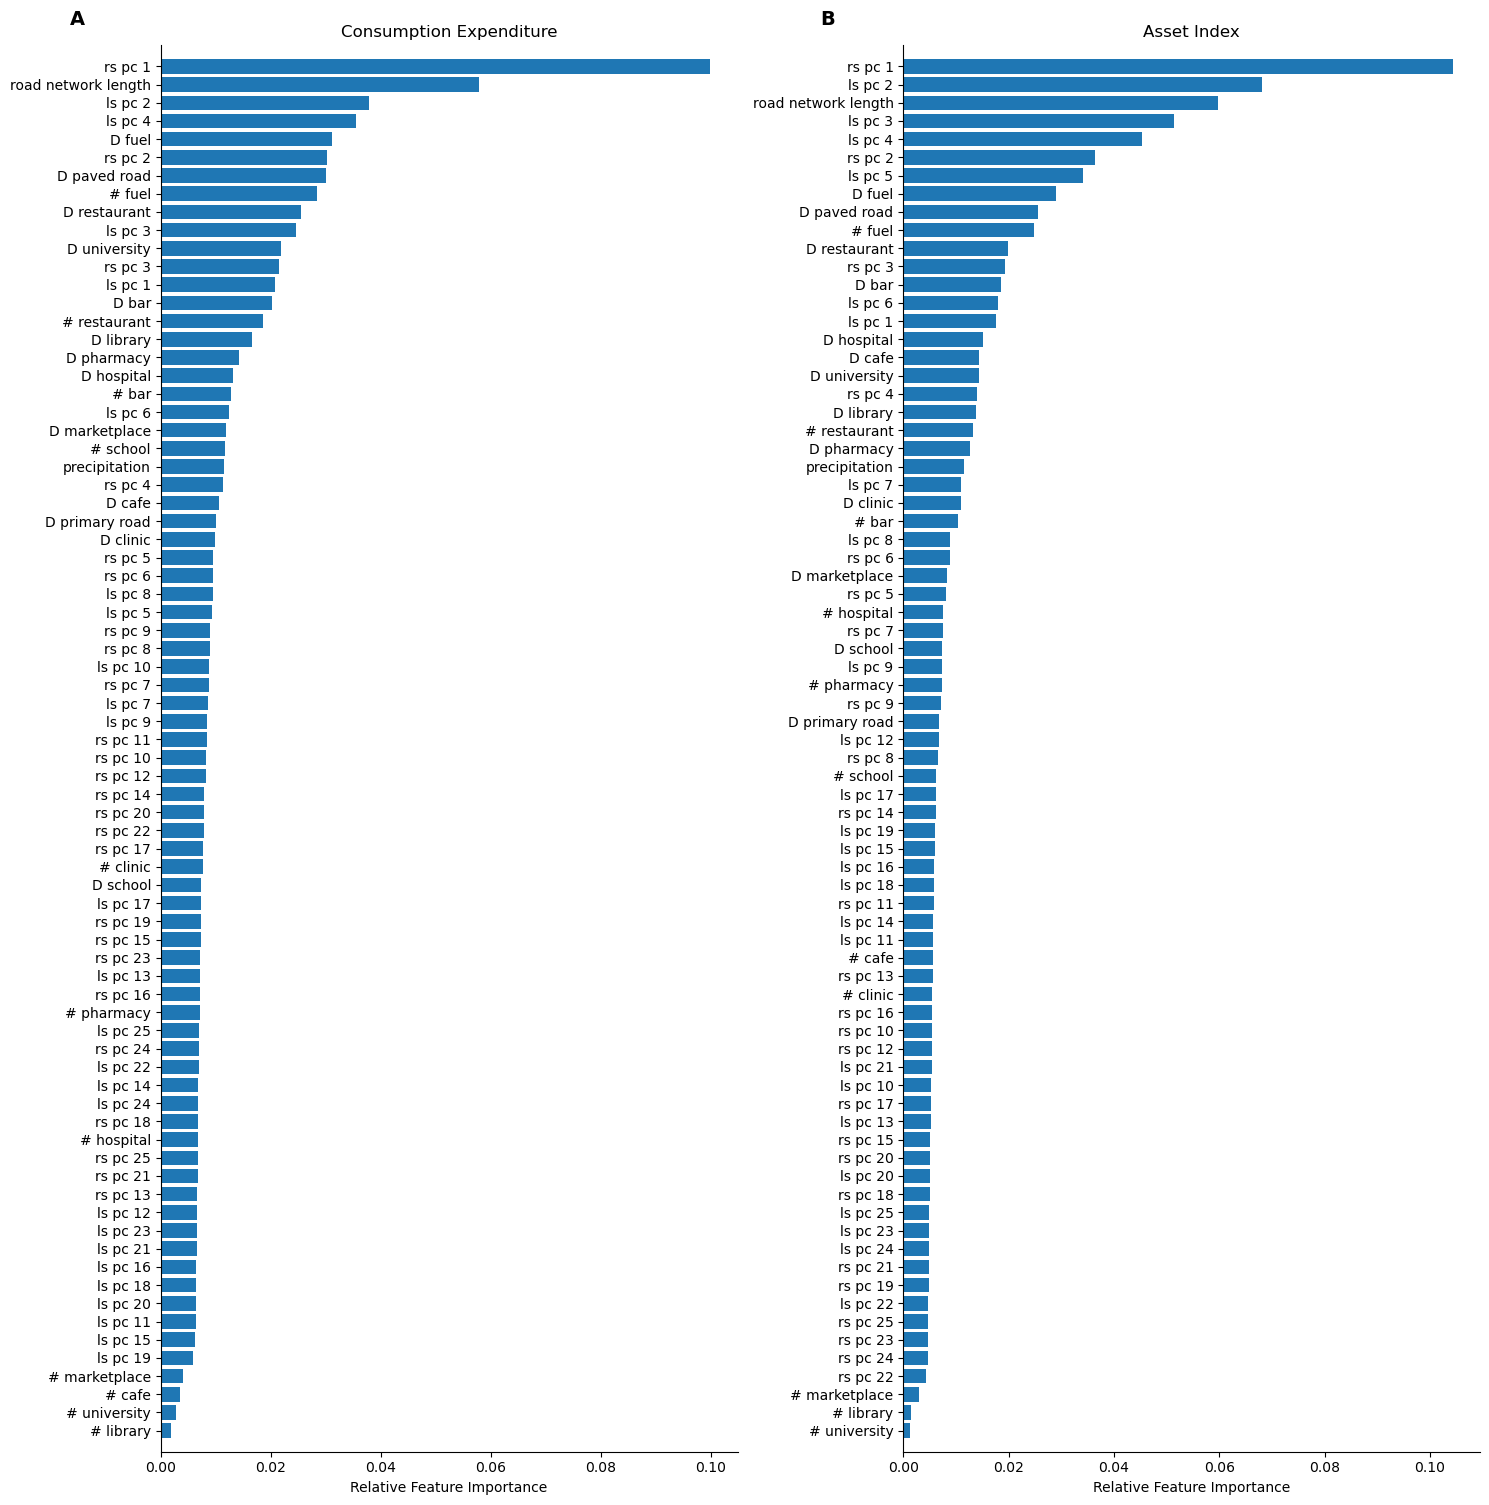

In [87]:
fig, ax = plt.subplots(1,2,figsize = (15,15))

ax[0].set_ymargin(0.01)
ax[0].barh(y = dl_cons.feat_importance['var_label'], width = dl_cons.feat_importance['feat_importance'])    
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].set_xlabel("Relative Feature Importance")
ax[0].set_title('Consumption Expenditure')


ax[1].set_ymargin(0.01)
ax[1].barh(y = dl_asset.feat_importance['var_label'], width = dl_asset.feat_importance['feat_importance'])    
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].set_xlabel("Relative Feature Importance")
ax[1].set_title('Asset Index')

fig.text(0.05,.99,'A',weight = 'bold', size = 14)
fig.text(0.55,.99,'B',weight = 'bold', size = 14)

plt.tight_layout()
pth = '../figures/results/dl_feature_importance.png'
plt.savefig(pth, dpi = 300, bbox_inches = 'tight')
plt.show()